<a href="https://colab.research.google.com/github/Nishant-Ramakuru/Inference-based-GNNS/blob/main/DNRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install jit

In [2]:
import time, os
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import argparse
import pickle
#import jit, cuda

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.optim import lr_scheduler
from matplotlib.pyplot import figure

import math
import networkx as nx

import random

os.environ['CUDA_LAUNCH_BLOCING'] = "1"

import torch.nn.functional as F
device = torch.randn([1]).device

In [3]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [4]:
'''
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/boids_buffer.rar", outdir="/content/drive/MyDrive")
'''

'\n!pip install patool\nimport patoolib\npatoolib.extract_archive("/content/drive/MyDrive/boids_buffer.rar", outdir="/content/drive/MyDrive")\n'

In [35]:
dataframe = pd.read_pickle('/content/drive/MyDrive/GNNs/boids_buffer_50.csv')

In [36]:
dataframe.index.rename('Time_Step',inplace = True)

In [37]:
print("Time steps:", dataframe.shape[0])
print("Number of Agents:", len(dataframe.R[0]))


Time steps: 800
Number of Agents: 50


In [38]:
dataframe.head(1)

,R,theta
Time_Step,,
0,"[[539.74475, 245.03323], [543.6497, 141.5064],...","[1.4382355, 1.8777844, 1.0181143, 2.6681843, 0..."


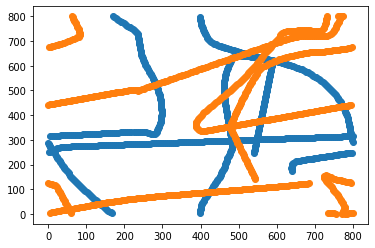

In [39]:

traj_1 = []
traj_2 = []
for i in range(len(dataframe)):
  traj_1.append(dataframe.R[i][0])
  traj_2.append(dataframe.R[i][1])
x,y = zip(*traj_1)  
p,q = zip(*traj_2)
plt.scatter(x,y)
plt.scatter(p,q)


**Functions**
---



In [40]:
def build_scheduler(opt, params):
    lr_decay_factor = params.get('lr_decay_factor')
    lr_decay_steps = params.get('lr_decay_steps')
    if lr_decay_factor:
        return torch.optim.lr_scheduler.StepLR(opt, lr_decay_steps, lr_decay_factor)
    else:
        return None


class build_writers:
    def __init__(self, working_dir, is_test=False):
        self.writer_dir = os.path.join(working_dir, 'logs/')
        self.is_test = is_test

    def __enter__(self):
        train_writer_dir = os.path.join(self.writer_dir, 'train')
        val_writer_dir = os.path.join(self.writer_dir, 'val')
        self.train_writer = SummaryWriter(train_writer_dir)
        self.val_writer = SummaryWriter(val_writer_dir)
        if self.is_test:
            test_writer_dir = os.path.join(self.writer_dir, 'test')
            self.test_writer = SummaryWriter(test_writer_dir)
            return self.train_writer, self.val_writer, self.test_writer
        else:
            return self.train_writer, self.val_writer

    def __exit__(self, type, value, traceback):
        self.train_writer.close()
        self.val_writer.close()
        if self.is_test:
            self.test_writer.close()

In [41]:
def seed(seed_val):
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    random.seed(seed_val)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_val)

In [42]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot

def highestPowerof2(n):
 
    res = 0;
    for i in range(n, 0, -1):
         
        # If i is a power of 2
        if ((i & (i - 1)) == 0):
         
            res = i;
            break;
         
    return res;



class RefNRIMLP(nn.Module):
    """Two-layer fully-connected ELU net with batch norm."""

    def __init__(self, n_in, n_hid, n_out, do_prob=0., no_bn=False):
        super(RefNRIMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_in, n_hid).to(device),
            nn.ELU(inplace=True).to(device),
            nn.Dropout(do_prob).to(device),
            nn.Linear(n_hid, n_out).to(device),
            nn.ELU(inplace=True).to(device)
        )
        if no_bn:
            self.bn = None
        else:
            self.bn = nn.BatchNorm1d(n_out)
        self.init_weights()

    def init_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.1)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def batch_norm(self, inputs):
        orig_shape = inputs.shape
        x = inputs.view(-1, inputs.size(-1))
        x = self.bn(x)
        return x.view(orig_shape)

    def forward(self, inputs):
        # Input shape: [num_sims, num_things, num_features]
        x = self.model(inputs)
        if self.bn is not None:
            return self.batch_norm(x)
        else:
            return x


def sample_gumbel(shape, eps=1e-10):
    """
    NOTE: Stolen from https://github.com/pytorch/pytorch/pull/3341/commits/327fcfed4c44c62b208f750058d14d4dc1b9a9d3
    Sample from Gumbel(0, 1)
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb ,
    (MIT license)
    """
    U = torch.rand(shape).float()
    return - torch.log(eps - torch.log(U + eps))


def gumbel_softmax_sample(logits, tau=1, eps=1e-10):
    """
    NOTE: Stolen from https://github.com/pytorch/pytorch/pull/3341/commits/327fcfed4c44c62b208f750058d14d4dc1b9a9d3
    Draw a sample from the Gumbel-Softmax distribution
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb
    (MIT license)
    """
    gumbel_noise = sample_gumbel(logits.size(), eps=eps)
    if logits.is_cuda:
        gumbel_noise = gumbel_noise.cuda()
    y = logits + gumbel_noise
    return F.softmax(y, dim=-1)


def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10):
    """
    NOTE: Stolen from https://github.com/pytorch/pytorch/pull/3341/commits/327fcfed4c44c62b208f750058d14d4dc1b9a9d3
    Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
      logits: [batch_size, n_class] unnormalized log-probs
      tau: non-negative scalar temperature
      hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
      [batch_size, n_class] sample from the Gumbel-Softmax distribution.
      If hard=True, then the returned sample will be one-hot, otherwise it will
      be a probability distribution that sums to 1 across classes
    Constraints:
    - this implementation only works on batch_size x num_features tensor for now
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb ,
    (MIT license)
    """
    y_soft = gumbel_softmax_sample(logits, tau=tau, eps=eps)
    if hard:
        shape = logits.size()
        _, k = y_soft.data.max(-1)
        # this bit is based on
        # https://discuss.pytorch.org/t/stop-gradients-for-st-gumbel-softmax/530/5
        y_hard = torch.zeros(*shape)
        if y_soft.is_cuda:
            y_hard = y_hard.cuda()
        y_hard = y_hard.zero_().scatter_(-1, k.view(shape[:-1] + (1,)), 1.0)
        # this cool bit of code achieves two things:
        # - makes the output value exactly one-hot (since we add then
        #   subtract y_soft value)
        # - makes the gradient equal to y_soft gradient (since we strip
        #   all other gradients)
        y = y_hard - y_soft.data + y_soft
    else:
        y = y_soft
    return y


def get_graph_info(masks, num_vars, use_edge2node=True):
    if num_vars == 1:
        return None, None, None
    edges = torch.ones(num_vars, device=masks.device) - torch.eye(num_vars, device=masks.device)
    tmp = torch.where(edges)
    send_edges = tmp[0]
    recv_edges = tmp[1]
    tmp_inds = torch.tensor(list(range(num_vars)), device=masks.device, dtype=torch.long).unsqueeze_(1)
    if use_edge2node:
        edge2node_inds = (tmp_inds == recv_edges.unsqueeze(0)).nonzero()[:, 1].contiguous().view(-1, num_vars-1)
        return send_edges, recv_edges, edge2node_inds
    else:
        return send_edges, recv_edges

**Model Definitions**
---




Parameters

In [44]:
params = {}
params['num_epochs'] = 10
params['num_vars'] = params['num_agents'] = len(dataframe.R[0])
params['input_noise_type'] = 'none'
params['input_size'] = params['num_agents']*2
params['nll_loss_type'] = 'gaussian'
params['prior_variance'] = 5e-5
params['batch_size'] = 10
params['val_batch_size'] = 10
params['accumulate_steps'] = 1
params['num_edge_types'] = 1
params['encoder_dropout'] = 0.5
params['encoder_hidden'] = highestPowerof2(params['input_size'])
params['encoder_rnn_hidden'] = 16
params['encoder_rnn_type'] = 'lstm'
params['encoder_mlp_num_layers'] = 2
params['encoder_mlp_hidden'] = 2
params['prior_num_layers'] = 2
params['prior_hidden_size'] = 16
params['gpu'] = False
params['decoder_hidden'] = 16
params['skip_first'] = True
params['decoder_dropout'] = 0.5
params['decoder_type'] = None
params['lr'] = 5e-4
params['working_dir'] = ('/content/MyDrive/GNNs')

In [45]:
data = []
for w in range(len(dataframe)):
  
  state = np.array(dataframe.R[w])
  D = list()
  for a,i in enumerate(state):
    d= []
    for b,j in enumerate(state):
      eDistance = math.hypot(i[0] - j[0], i[1] - j[1])
      if a == b:
        d.append(0)
      elif int(eDistance) <= 100:
        d.append(1)
      else:
        d.append(0)
    D.append(d)

  data.append(np.array(D))

In [46]:
#dataset = np.array(data)
#dataset.shape

In [47]:
#del data
#del dataframe

In [48]:
def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=30, labels=mylabels, with_labels=False)
    plt.show()

In [50]:
figure(figsize=(100,100), dpi=80)

<Figure size 8000x8000 with 0 Axes>

<Figure size 8000x8000 with 0 Axes>

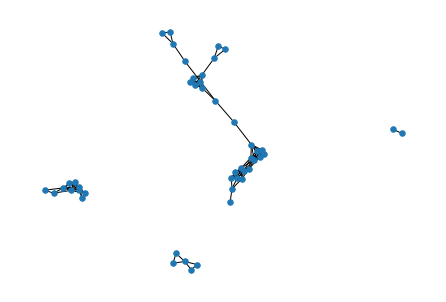

In [51]:
x = [str(i) for i in range(0,50)]
show_graph_with_labels(data[700],x)

Encoder

In [52]:
class DNRI_Encoder(nn.Module):
    # Here, encoder also produces prior
    def __init__(self, params):
        super(DNRI_Encoder, self).__init__()
        num_vars = params['num_vars']
        self.num_edges = params['num_edge_types']
        self.sepaate_prior_encoder = params.get('separate_prior_encoder', False)
        no_bn = False
        dropout = params['encoder_dropout']
        edges = np.ones(num_vars) - np.eye(num_vars)
        self.send_edges = np.where(edges)[0]
        self.recv_edges = np.where(edges)[1]
        self.edge2node_mat = nn.Parameter(torch.FloatTensor(encode_onehot(self.recv_edges).transpose()), requires_grad=False)
        self.save_eval_memory = params.get('encoder_save_eval_memory', False)


        hidden_size = params['encoder_hidden']
        rnn_hidden_size = params['encoder_rnn_hidden']
        rnn_type = params['encoder_rnn_type']
        inp_size = params['input_size']
        self.mlp1 = RefNRIMLP(inp_size, hidden_size*16, hidden_size*8, dropout, no_bn=no_bn).to(device)
        self.mlp2 = RefNRIMLP(hidden_size*8, hidden_size*4, hidden_size*2, dropout, no_bn=no_bn).to(device)
        self.mlp3 = RefNRIMLP(hidden_size*2, hidden_size, int(hidden_size*0.5), dropout, no_bn=no_bn).to(device)
        self.mlp4 = RefNRIMLP(int(hidden_size*0.5), int(hidden_size*0.25), int(hidden_size*0.25), dropout, no_bn=no_bn).to(device)

        if rnn_hidden_size is None:
            rnn_hidden_size = hidden_size
        if rnn_type == 'lstm':
            self.forward_rnn = nn.LSTM(int(hidden_size*0.25), rnn_hidden_size, batch_first=True)
            self.reverse_rnn = nn.LSTM(int(hidden_size*0.25), rnn_hidden_size, batch_first=True)
        elif rnn_type == 'gru':
            self.forward_rnn = nn.GRU(hidden_size, rnn_hidden_size, batch_first=True)
            self.reverse_rnn = nn.GRU(hidden_size, rnn_hidden_size, batch_first=True)
        out_hidden_size = 2*rnn_hidden_size
        num_layers = params['encoder_mlp_num_layers']
        if num_layers == 1:
            self.encoder_fc_out = nn.Linear(out_hidden_size, self.num_edges)
        else:
            tmp_hidden_size = params['encoder_mlp_hidden']
            layers = [nn.Linear(out_hidden_size, tmp_hidden_size), nn.ELU(inplace=True)]
            for _ in range(num_layers - 2):
                layers.append(nn.Linear(tmp_hidden_size, tmp_hidden_size))
                layers.append(nn.ELU(inplace=True))
            layers.append(nn.Linear(tmp_hidden_size, self.num_edges))
            self.encoder_fc_out = nn.Sequential(*layers)

        num_layers = params['prior_num_layers']
        if num_layers == 1:
            self.prior_fc_out = nn.Linear(rnn_hidden_size, self.num_edges)
        else:
            tmp_hidden_size = params['prior_hidden_size']
            layers = [nn.Linear(rnn_hidden_size, tmp_hidden_size), nn.ELU(inplace=True)]
            for _ in range(num_layers - 2):
                layers.append(nn.Linear(tmp_hidden_size, tmp_hidden_size))
                layers.append(nn.ELU(inplace=True))
            layers.append(nn.Linear(tmp_hidden_size, self.num_edges))
            self.prior_fc_out = nn.Sequential(*layers)


        self.num_vars = num_vars
        edges = np.ones(num_vars) - np.eye(num_vars)
        self.send_edges = np.where(edges)[0]
        self.recv_edges = np.where(edges)[1]

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.1)

    def node2edge(self, node_embeddings):
        # Input size: [batch, num_vars, num_timesteps, embed_size]
        if len(node_embeddings.shape) == 4:
            send_embed = node_embeddings[:, self.send_edges, :, :]
            recv_embed = node_embeddings[:, self.recv_edges, :, :]
        else:

            send_embed = node_embeddings[:, self.send_edges, :]
            recv_embed = node_embeddings[:, self.recv_edges, :]
            #send_embed = node_embeddings[:, self.send_edges, :]
            #recv_embed = node_embeddings[:, self.recv_edges, :]
        return torch.cat([send_embed, recv_embed], dim=-1)

    def edge2node(self, edge_embeddings):
        if len(edge_embeddings.shape) == 4:
            old_shape = edge_embeddings.shape
            tmp_embeddings = edge_embeddings.view(old_shape[0], old_shape[1], -1)
            incoming = torch.matmul(self.edge2node_mat, tmp_embeddings).view(old_shape[0], -1, old_shape[2], old_shape[3])
        else:
            incoming = torch.matmul(self.edge2node_mat, edge_embeddings)
        return incoming/(self.num_vars-1) #TODO: do we want this average?


    def copy_states(self, prior_state):
        if isinstance(prior_state, tuple) or isinstance(prior_state, list):
            current_prior_state = (prior_state[0].clone(), prior_state[1].clone())
        else:
            current_prior_state = prior_state.clone()
        return current_prior_state

    def merge_hidden(self, hidden):
        if isinstance(hidden[0], tuple) or isinstance(hidden[0], list):
            result0 = torch.cat([x[0] for x in hidden], dim=0)
            result1 = torch.cat([x[1] for x in hidden], dim=0)
            result = (result0, result1)
        else:
            result = torch.cat(hidden, dim=0)
        return result



    def forward(self, inputs):
        if self.training or not self.save_eval_memory:
            # Inputs is shape [batch, num_timesteps, num_vars, input_size]
            num_timesteps = inputs.size(1)
            x = inputs.contiguous().to(inputs.device)
            # New shape: [num_sims, num_atoms, num_timesteps, num_dims]
            x = self.mlp1(x)  # 2-layer ELU net per node
            #x = self.node2edge(x)
            x = self.mlp2(x)
            #x_skip = x
            #x = self.edge2node(x)
            x = self.mlp3(x)
            #x = self.node2edge(x)
            #x = torch.cat((x, x_skip), dim=-1)  # Skip connection
            x = self.mlp4(x)
        
            
            # At this point, x should be [batch, num_edges, num_timesteps, hidden_size]
            # RNN aggregation
            old_shape = x.shape

            x = x.contiguous().view(-1, old_shape[0], old_shape[1])
            forward_x, prior_state = self.forward_rnn(x)
            timesteps = old_shape[1]
            reverse_x = x.flip(1)
            reverse_x, _ = self.reverse_rnn(reverse_x)
            reverse_x = reverse_x.flip(1)
            
            #x: [batch*num_edges, num_timesteps, hidden_size]

            #timesteps = 2
            #self.num_edges = 1
            prior_result = self.prior_fc_out(forward_x).view(old_shape[0]).contiguous()
            combined_x = torch.cat([forward_x, reverse_x], dim=-1)
            encoder_result = self.encoder_fc_out(combined_x).view(old_shape[0]).contiguous()
            return prior_result, encoder_result, prior_state
        else:
            # Inputs is shape [batch, num_timesteps, num_vars, input_size]
            num_timesteps = inputs.size(1)
            all_x = []
            all_forward_x = []
            all_prior_result = []
            prior_state = None
            for timestep in range(num_timesteps):
                x = inputs[:, timestep]
                #x = inputs.transpose(2, 1).contiguous()
                x = self.mlp1(x)  # 2-layer ELU net per node
                x = self.node2edge(x)
                x = self.mlp2(x)
                x_skip = x
                x = self.edge2node(x)
                x = self.mlp3(x)
                x = self.node2edge(x)
                x = torch.cat((x, x_skip), dim=-1)  # Skip connection
                x = self.mlp4(x)
            
                
                # At this point, x should be [batch, num_edges, num_timesteps, hidden_size]
                # RNN aggregation
                old_shape = x.shape
                x = x.contiguous().view(-1, 1, old_shape[-1])
                forward_x, prior_state = self.forward_rnn(x, prior_state)
                all_x.append(x.cpu())
                all_forward_x.append(forward_x.cpu())
                all_prior_result.append(self.prior_fc_out(forward_x).view(old_shape[0], 1, old_shape[1], self.num_edges).cpu())
            reverse_state = None
            all_encoder_result = []
            for timestep in range(num_timesteps-1, -1, -1):
                x = all_x[timestep].cuda()
                reverse_x, reverse_state = self.reverse_rnn(x, reverse_state)
                forward_x = all_forward_x[timestep].cuda()
                
                #x: [batch*num_edges, num_timesteps, hidden_size]
                combined_x = torch.cat([forward_x, reverse_x], dim=-1)
                all_encoder_result.append(self.encoder_fc_out(combined_x).view(inputs.size(0), 1, -1, self.num_edges))
            prior_result = torch.cat(all_prior_result, dim=1).cuda(non_blocking=True)
            encoder_result = torch.cat(all_encoder_result, dim=1).cuda(non_blocking=True)
            return prior_result, encoder_result, prior_state

    def single_step_forward(self, inputs, prior_state):
        # Inputs is shape [batch, num_vars, input_size]
        x = self.mlp1(inputs)  # 2-layer ELU net per node
        x = self.node2edge(x)
        x = self.mlp2(x)
        x_skip = x
        x = self.edge2node(x)
        x = self.mlp3(x)
        x = self.node2edge(x)
        x = torch.cat((x, x_skip), dim=-1)  # Skip connection
        x = self.mlp4(x)

        old_shape = x.shape
        x  = x.contiguous().view(-1, 1, old_shape[-1])
        old_prior_shape = prior_state[0].shape
        prior_state = (prior_state[0].view(-1, old_prior_shape[0]*old_prior_shape[1], old_prior_shape[2]),
                       prior_state[1].view(-1, old_prior_shape[0]*old_prior_shape[1], old_prior_shape[2]))

        x, prior_state = self.forward_rnn(x, prior_state)
        prior_result = self.prior_fc_out(x).view(old_shape[0], old_shape[1], self.num_edges)
        prior_state = (prior_state[0].view(old_prior_shape), prior_state[1].view(old_prior_shape))
        return prior_result, prior_state

In [53]:
#encoder = DNRI_Encoder(params)

Decoder

In [54]:
class DNRI_Decoder(nn.Module):
    def __init__(self, params):
        super(DNRI_Decoder, self).__init__()
        self.num_vars = num_vars =  params['num_vars']
        input_size = params['input_size']
        self.gpu = params['gpu']
        n_hid = params['decoder_hidden']
        edge_types = params['num_edge_types']
        skip_first = params['skip_first']
        out_size = params['input_size']
        do_prob = params['decoder_dropout']

        self.msg_fc1 = nn.ModuleList(
            [nn.Linear(2*n_hid, n_hid) for _ in range(edge_types)]
        )
        self.msg_fc2 = nn.ModuleList(
            [nn.Linear(n_hid, n_hid) for _ in range(edge_types)]
        )
        self.msg_out_shape = n_hid
        self.skip_first_edge_type = skip_first
        '''
        self.hidden_r = nn.Linear(n_hid, n_hid, bias=False)
        self.hidden_i = nn.Linear(n_hid, n_hid, bias=False)
        self.hidden_h = nn.Linear(n_hid, n_hid, bias=False)

        self.input_r = nn.Linear(input_size, n_hid, bias=True)
        self.input_i = nn.Linear(input_size, n_hid, bias=True)
        self.input_n = nn.Linear(input_size, n_hid, bias=True)
        '''
        self.out_fc1 = nn.Linear(n_hid, n_hid)
        self.out_fc2 = nn.Linear(n_hid, n_hid)
        self.out_fc3 = nn.Linear(n_hid, out_size)

        print('Using learned recurrent interaction net decoder.')

        self.dropout_prob = do_prob

        self.num_vars = num_vars
        edges = np.ones(num_vars) - np.eye(num_vars)
        self.send_edges = np.where(edges)[0]
        self.recv_edges = np.where(edges)[1]
        self.edge2node_mat = nn.Parameter(torch.FloatTensor(encode_onehot(self.recv_edges)), requires_grad=False)

    def get_initial_hidden(self, inputs):
        return torch.zeros(inputs.size(0), inputs.size(1), self.msg_out_shape, device=inputs.device)
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.1)

    def forward(self, inputs, hidden, edges):
        # Input Size: [batch, num_vars, input_size]
        # Hidden Size: [batch, num_vars, rnn_hidden]
        # Edges size: [batch, num_edges, num_edge_types]
        if self.training:
            dropout_prob = self.dropout_prob
        else:
            dropout_prob = 0.
        '''
        # node2edge
        print(hidden.shape)
        #receivers = hidden[:, self.recv_edges, :]
        #senders = hidden[:, self.send_edges, :]
        receivers = hidden
        senders = hidden

        # pre_msg: [batch, num_edges, 2*msg_out]
        pre_msg = torch.cat([receivers, senders], dim=-1)

        all_msgs = torch.zeros(pre_msg.size(0), pre_msg.size(1),
                                        self.msg_out_shape, device=inputs.device)
        
        if self.skip_first_edge_type:
            start_idx = 1
            norm = float(len(self.msg_fc2)) - 1
        else:
            start_idx = 0
            norm = float(len(self.msg_fc2))

        # Run separate MLP for every edge type
        # NOTE: to exclude one edge type, simply offset range by 1
        for i in range(start_idx, len(self.msg_fc2)):
            msg = torch.tanh(self.msg_fc1[i](pre_msg))
            msg = F.dropout(msg, p=dropout_prob)
            msg = torch.tanh(self.msg_fc2[i](msg))
            msg = msg * edges[:, i:i+1]

            all_msgs += msg/norm

        # This step sums all of the messages per node
        agg_msgs = all_msgs.transpose(-2, -1).matmul(self.edge2node_mat).transpose(-2, -1)
        agg_msgs = agg_msgs.contiguous() / (self.num_vars - 1) # Average
        '''
        # Output MLP
        pred = F.dropout(F.relu(self.out_fc1(hidden)), p=dropout_prob)
        pred = F.dropout(F.relu(self.out_fc2(pred)), p=dropout_prob)
        pred = F.dropout(F.relu(self.out_fc3(pred)), p=dropout_prob)

        #pred = inputs + pred
        pred = pred[0][0][:]
        #print('pred size', pred.shape)
        #print('input_size', inputs.shape)

        return pred, hidden

DNRI

In [55]:
class DNRI(nn.Module):
    def __init__(self, params):
        super(DNRI, self).__init__()
        # Model Params
        self.num_vars = params['num_vars']
        self.encoder = DNRI_Encoder(params)
        self.decoder = DNRI_Decoder(params)
        self.num_edge_types = params.get('num_edge_types')

        # Training params
        self.gumbel_temp = params.get('gumbel_temp')
        self.train_hard_sample = params.get('train_hard_sample')
        self.teacher_forcing_steps = params.get('teacher_forcing_steps', -1)
        
        self.normalize_kl = params.get('normalize_kl', False)
        self.normalize_kl_per_var = params.get('normalize_kl_per_var', False)
        self.normalize_nll = params.get('normalize_nll', False)
        self.normalize_nll_per_var = params.get('normalize_nll_per_var', False)
        self.kl_coef = params.get('kl_coef', 1.)
        self.nll_loss_type = params.get('nll_loss_type', 'crossent')
        self.prior_variance = params.get('prior_variance')
        self.timesteps = params.get('timesteps', 0)
        self.burn_in_steps = params.get('train_burn_in_steps')
        self.teacher_forcing_prior = params.get('teacher_forcing_prior', False)
        self.val_teacher_forcing_steps = params.get('val_teacher_forcing_steps', -1)
        self.add_uniform_prior = params.get('add_uniform_prior')
        if self.add_uniform_prior:
            if params.get('no_edge_prior') is not None:
                prior = np.zeros(self.num_edge_types)
                prior.fill((1 - params['no_edge_prior'])/(self.num_edge_types - 1))
                prior[0] = params['no_edge_prior']
                log_prior = torch.FloatTensor(np.log(prior))
                log_prior = torch.unsqueeze(log_prior, 0)
                log_prior = torch.unsqueeze(log_prior, 0)
                if params['gpu']:
                    log_prior = log_prior.cuda(non_blocking=True)
                self.log_prior = log_prior
                print("USING NO EDGE PRIOR: ",self.log_prior)
            else:
                print("USING UNIFORM PRIOR")
                prior = np.zeros(self.num_edge_types)
                prior.fill(1.0/self.num_edge_types)
                log_prior = torch.FloatTensor(np.log(prior))
                log_prior = torch.unsqueeze(log_prior, 0)
                log_prior = torch.unsqueeze(log_prior, 0)
                if params['gpu']:
                    log_prior = log_prior.cuda(non_blocking=True)
                self.log_prior = log_prior

    def single_step_forward(self, inputs, decoder_hidden, edge_logits, hard_sample):
        old_shape = edge_logits.shape
        edges = gumbel_softmax(
            edge_logits.reshape(-1, self.num_edge_types), 
            tau=self.gumbel_temp, 
            hard=hard_sample).view(old_shape)
        predictions, decoder_hidden = self.decoder(inputs, decoder_hidden, edges)
        return predictions, decoder_hidden, edges

    def calculate_loss(self, inputs, is_train=False, teacher_forcing=True, return_edges=False, return_logits=False, use_prior_logits=False):
        decoder_hidden = self.decoder.get_initial_hidden(inputs)
        num_time_steps = inputs.size(0)
        all_edges = []
        all_predictions = []
        all_priors = []
        hard_sample = (not is_train) or self.train_hard_sample
        prior_logits, posterior_logits, _ = self.encoder(inputs[:, :])
        if not is_train:
            teacher_forcing_steps = self.val_teacher_forcing_steps
        else:
            teacher_forcing_steps = self.teacher_forcing_steps
        for step in range(num_time_steps):
            if (teacher_forcing and (teacher_forcing_steps == -1 or step < teacher_forcing_steps)) or step == 0:
                current_inputs = inputs[step]
            else:
                current_inputs = predictions
            if not use_prior_logits:
                current_p_logits = posterior_logits[step]
            else:
                current_p_logits = prior_logits[step]
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs, decoder_hidden, current_p_logits, hard_sample)
            all_predictions.append(predictions)
            all_edges.append(edges)
        
        all_predictions = torch.stack(all_predictions, dim=0)
        target = inputs[:,:]
        loss_nll = self.nll(all_predictions, target)
        prob = F.softmax(posterior_logits, dim=-1)
        loss_kl = self.kl_categorical_learned(prob, prior_logits)
        if self.add_uniform_prior:
            loss_kl = 0.5*loss_kl + 0.5*self.kl_categorical_avg(prob)
        loss = loss_nll + self.kl_coef*loss_kl
        loss = loss.mean()

        if return_edges:
            return loss, loss_nll, loss_kl, edges
        elif return_logits:
            return loss, loss_nll, loss_kl, posterior_logits, all_predictions
        else:
            return loss, loss_nll, loss_kl

    def predict_future(self, inputs, prediction_steps, return_edges=False, return_everything=False):
        burn_in_timesteps = inputs.size(0)
        decoder_hidden = self.decoder.get_initial_hidden(inputs)
        all_predictions = []
        all_edges = []
        prior_logits, _, prior_hidden = self.encoder(inputs[:, :])
        for step in range(burn_in_timesteps-1):
            current_inputs = inputs[:, step]
            current_edge_logits = prior_logits[:, step]
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs, decoder_hidden, current_edge_logits, True)
            if return_everything:
                all_edges.append(edges)
                all_predictions.append(predictions)
        predictions = inputs[:, burn_in_timesteps-1]
        for step in range(prediction_steps):
            current_edge_logits, prior_hidden = self.encoder.single_step_forward(predictions, prior_hidden)
            predictions, decoder_hidden, edges = self.single_step_forward(predictions, decoder_hidden, current_edge_logits, True)
            all_predictions.append(predictions)
            all_edges.append(edges)
        
        predictions = torch.stack(all_predictions, dim=1)
        if return_edges:
            edges = torch.stack(all_edges, dim=1)
            return predictions, edges
        else:
            return predictions

    def copy_states(self, state):
        if isinstance(state, tuple) or isinstance(state, list):
            current_state = (state[0].clone(), state[1].clone())
        else:
            current_state = state.clone()
        return current_state

    def merge_hidden(self, hidden):
        if isinstance(hidden[0], tuple) or isinstance(hidden[0], list):
            result0 = torch.cat([x[0] for x in hidden], dim=0)
            result1 = torch.cat([x[1] for x in hidden], dim=0)
            return (result0, result1)
        else:
            return torch.cat(hidden, dim=0)

    def predict_future_fixedwindow(self, inputs, burn_in_steps, prediction_steps, batch_size, return_edges=False):
        print("INPUT SHAPE: ",inputs.shape)
        prior_logits, _, prior_hidden = self.encoder(inputs[:, :])
        decoder_hidden = self.decoder.get_initial_hidden(inputs)
        for step in range(burn_in_steps-1):
            current_inputs = inputs[:, step]
            current_edge_logits = prior_logits[:, step]
            predictions, decoder_hidden, _ = self.single_step_forward(current_inputs, decoder_hidden, current_edge_logits, True)
        all_timestep_preds = []
        all_timestep_edges = []
        for window_ind in range(burn_in_steps - 1, inputs.size(1)-1, batch_size):
            current_batch_preds = []
            current_batch_edges = []
            prior_states = []
            decoder_states = []
            for step in range(batch_size):
                if window_ind + step >= inputs.size(1):
                    break
                predictions = inputs[:, window_ind + step] 
                current_edge_logits, prior_hidden = self.encoder.single_step_forward(predictions, prior_hidden)
                predictions, decoder_hidden, _ = self.single_step_forward(predictions, decoder_hidden, current_edge_logits, True)
                current_batch_preds.append(predictions)
                tmp_prior = self.encoder.copy_states(prior_hidden)
                tmp_decoder = self.copy_states(decoder_hidden)
                prior_states.append(tmp_prior)
                decoder_states.append(tmp_decoder)
                if return_edges:
                    current_batch_edges.append(current_edge_logits.cpu())
            batch_prior_hidden = self.encoder.merge_hidden(prior_states)
            batch_decoder_hidden = self.merge_hidden(decoder_states)
            current_batch_preds = torch.cat(current_batch_preds, 0)
            current_timestep_preds = [current_batch_preds]
            if return_edges:
                current_batch_edges = torch.cat(current_batch_edges, 0)
                current_timestep_edges = [current_batch_edges]
            for step in range(prediction_steps - 1):
                current_batch_edge_logits, batch_prior_hidden = self.encoder.single_step_forward(current_batch_preds, batch_prior_hidden)
                current_batch_preds, batch_decoder_hidden, _ = self.single_step_forward(current_batch_preds, batch_decoder_hidden, current_batch_edge_logits, True)
                current_timestep_preds.append(current_batch_preds)
                if return_edges:
                    current_timestep_edges.append(current_batch_edge_logits.cpu())
            all_timestep_preds.append(torch.stack(current_timestep_preds, dim=1))
            if return_edges:
                all_timestep_edges.append(torch.stack(current_timestep_edges, dim=1))
        result =  torch.cat(all_timestep_preds, dim=0)
        if return_edges:
            edge_result = torch.cat(all_timestep_edges, dim=0)
            return result.unsqueeze(0), edge_result.unsqueeze(0)
        else:
            return result.unsqueeze(0)

    def nll(self, preds, target):
        if self.nll_loss_type == 'crossent':
            return self.nll_crossent(preds, target)
        elif self.nll_loss_type == 'gaussian':
            return self.nll_gaussian(preds, target)
        elif self.nll_loss_type == 'poisson':
            return self.nll_poisson(preds, target)

    def nll_gaussian(self, preds, target, add_const=False):
        #print(preds.shape,target.shape)
        neg_log_p = ((preds - target) ** 2 / (2 * self.prior_variance))
        const = 0.5 * np.log(2 * np.pi * self.prior_variance)
        #neg_log_p += const
        if self.normalize_nll_per_var:
            return neg_log_p.sum() / (target.size(0) * target.size(2))
        elif self.normalize_nll:
            return (neg_log_p.sum(-1) + const).view(preds.size(0), -1).mean(dim=1)
        else:
            return neg_log_p.view(target.size(0), -1).sum() / (target.size(1))


    def nll_crossent(self, preds, target):
        if self.normalize_nll:
            return nn.BCEWithLogitsLoss(reduction='none')(preds, target).view(preds.size(0), -1).mean(dim=1)
        else:
            return nn.BCEWithLogitsLoss(reduction='none')(preds, target).view(preds.size(0), -1).sum(dim=1)

    def nll_poisson(self, preds, target):
        if self.normalize_nll:
            return nn.PoissonNLLLoss(reduction='none')(preds, target).view(preds.size(0), -1).mean(dim=1)
        else:
            return nn.PoissonNLLLoss(reduction='none')(preds, target).view(preds.size(0), -1).sum(dim=1)

    def kl_categorical_learned(self, preds, prior_logits):
        log_prior = nn.LogSoftmax(dim=-1)(prior_logits)
        kl_div = preds*(torch.log(preds + 1e-16) - log_prior)
        if self.normalize_kl:     
            return kl_div.sum(-1).view(preds.size(0), -1).mean(dim=1)
        elif self.normalize_kl_per_var:
            return kl_div.sum() / (self.num_vars * preds.size(0))
        else:
            return kl_div.view(preds.size(0), -1).sum(dim=1)

    def kl_categorical_avg(self, preds, eps=1e-16):
        avg_preds = preds.mean(dim=2)
        kl_div = avg_preds*(torch.log(avg_preds+eps) - self.log_prior)
        if self.normalize_kl:     
            return kl_div.sum(-1).view(preds.size(0), -1).mean(dim=1)
        elif self.normalize_kl_per_var:
            return kl_div.sum() / (self.num_vars * preds.size(0))
        else:
            return kl_div.view(preds.size(0), -1).sum(dim=1)


    def save(self, path):
        #torch.save(self.state_dict(), path)
        pass
    def load(self, path):
        self.load_state_dict(torch.load(path))

Build Model

In [56]:
def build_model(params):        
  model = DNRI(params)
  print("dNRI MODEL: ",model)

  if params['gpu'] == True:
    model.cuda()
    
  return model

In [57]:
model = build_model(params)

Using learned recurrent interaction net decoder.
dNRI MODEL:  DNRI(
  (encoder): DNRI_Encoder(
    (mlp1): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=100, out_features=1024, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.5, inplace=False)
        (3): Linear(in_features=1024, out_features=512, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.5, inplace=False)
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
      )
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): RefNRIMLP(
      (model): Sequential(
        (0): Linear(i

Train

In [58]:
def train(model, train_data, val_data, params, train_writer, val_writer):
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    val_batch_size = params.get('val_batch_size', batch_size)
    if val_batch_size is None:
        val_batch_size = batch_size
    accumulate_steps = params.get('accumulate_steps')
    training_scheduler = params.get('training_scheduler', None)
    num_epochs = params.get('num_epochs', 2)
    val_interval = params.get('val_interval', 1)
    val_start = params.get('val_start', 0)
    clip_grad = params.get('clip_grad', None)
    clip_grad_norm = params.get('clip_grad_norm', None)
    normalize_nll = params.get('normalize_nll', False)
    normalize_kl = params.get('normalize_kl', False)
    tune_on_nll = params.get('tune_on_nll', False)
    verbose = params.get('verbose', False)
    val_teacher_forcing = params.get('val_teacher_forcing', False)
    continue_training = params.get('continue_training', False)
    train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_data_loader = DataLoader(val_data, batch_size=val_batch_size)
    lr = params['lr']
    wd = params.get('wd', 0.)
    mom = params.get('mom', 0.)
    
    model_params = [param for param in model.parameters() if param.requires_grad]
    if params.get('use_adam', False):
        opt = torch.optim.Adam(model_params, lr=lr, weight_decay=wd)
    else:
        opt = torch.optim.SGD(model_params, lr=lr, weight_decay=wd, momentum=mom)

    working_dir = params['working_dir']
    best_path = os.path.join(working_dir, 'best_model')
    checkpoint_dir = os.path.join(working_dir, '')
    training_path = os.path.join(working_dir, '')
    if continue_training:
        print("RESUMING TRAINING")
        model.load(checkpoint_dir)
        train_params = torch.load(training_path)
        start_epoch = train_params['epoch']
        opt.load_state_dict(train_params['optimizer'])
        best_val_result = train_params['best_val_result']
        best_val_epoch = train_params['best_val_epoch']
        print("STARTING EPOCH: ",start_epoch)
    else:
        start_epoch = 1
        best_val_epoch = -1
        best_val_result = 10000000
    
    training_scheduler = build_scheduler(opt, params)
    end = start = 0 
    seed(1)
    for epoch in range(start_epoch, num_epochs+1):
        print("EPOCH", epoch, (end-start))
        model.train()
        model.train_percent = epoch / num_epochs
        start = time.time() 
        for batch_ind, batch in enumerate(train_data_loader):
            inputs = batch.to(device)
            if gpu:
                inputs = inputs.cuda(non_blocking=True)
            loss, loss_nll, loss_kl, logits, _ = model.calculate_loss(inputs, is_train=True, return_logits=True)
            loss.backward()
            if verbose:
                print("\tBATCH %d OF %d: %f, %f, %f"%(batch_ind+1, len(train_data_loader), loss.item(), loss_nll.mean().item(), loss_kl.mean().item()))
            if accumulate_steps == -1 or (batch_ind+1)%accumulate_steps == 0:
                if verbose and accumulate_steps > 0:
                    print("\tUPDATING WEIGHTS")
                if clip_grad is not None:
                    nn.utils.clip_grad_value_(model.parameters(), clip_grad)
                elif clip_grad_norm is not None:
                    nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)        
                opt.step()
                opt.zero_grad()
                if accumulate_steps > 0 and accumulate_steps > len(train_data_loader) - batch_ind - 1:
                    break
            
        if training_scheduler is not None:
            training_scheduler.step()
        
        if train_writer is not None:
            train_writer.add_scalar('loss', loss.item(), global_step=epoch)
            if normalize_nll:
                train_writer.add_scalar('NLL', loss_nll.mean().item(), global_step=epoch)
            else:
                train_writer.add_scalar('NLL', loss_nll.mean().item()/(inputs.size(1)*inputs.size(2)), global_step=epoch)
            
            train_writer.add_scalar("KL Divergence", loss_kl.mean().item(), global_step=epoch)
        model.eval()
        opt.zero_grad()

        total_nll = 0
        total_kl = 0
        if verbose:
            print("COMPUTING VAL LOSSES")
        with torch.no_grad():
            for batch_ind, batch in enumerate(val_data_loader):
                inputs = batch
                if gpu:
                    inputs = inputs.cuda(non_blocking=True)
                loss, loss_nll, loss_kl, logits, _ = model.calculate_loss(inputs, is_train=False, teacher_forcing=val_teacher_forcing, return_logits=True)
                total_kl += loss_kl.sum().item()
                total_nll += loss_nll.sum().item()
                if verbose:
                    print("\tVAL BATCH %d of %d: %f, %f"%(batch_ind+1, len(val_data_loader), loss_nll.mean(), loss_kl.mean()))
            
        total_kl /= len(val_data)
        total_nll /= len(val_data)
        total_loss = model.kl_coef*total_kl + total_nll #TODO: this is a thing you fixed
        if val_writer is not None:
            val_writer.add_scalar('loss', total_loss, global_step=epoch)
            val_writer.add_scalar("NLL", total_nll, global_step=epoch)
            val_writer.add_scalar("KL Divergence", total_kl, global_step=epoch)
        if tune_on_nll:
            tuning_loss = total_nll
        else:
            tuning_loss = total_loss
        if tuning_loss < best_val_result:
            best_val_epoch = epoch
            best_val_result = tuning_loss
            print("BEST VAL RESULT. SAVING MODEL...")
            model.save(best_path)
        model.save(checkpoint_dir)
        '''
        torch.save({
                    'epoch':epoch+1,
                    'optimizer':opt.state_dict(),
                    'best_val_result':best_val_result,
                    'best_val_epoch':best_val_epoch,
                   }, training_path)
        '''
        print("EPOCH %d EVAL: "%epoch)
        print("\tCURRENT VAL LOSS: %f"%tuning_loss)
        print("\tBEST VAL LOSS:    %f"%best_val_result)
        print("\tBEST VAL EPOCH:   %d"%best_val_epoch)
        end = time.time()

    return model

In [59]:
train_dataset = np.array([np.array(i) for i in dataframe[:100].R])
test_dataset = np.array([np.array(i) for i in dataframe[100:150].R])

In [60]:
train_dataset = ((train_dataset - train_dataset.min()) / (train_dataset.max() - train_dataset.min())).reshape(100,params['input_size'])

In [61]:
test_dataset = (test_dataset - train_dataset.min() / (train_dataset.max() - train_dataset.min())).reshape(50,params['input_size'])

In [62]:
#train_dataset = np.split(dataset,2)[0].astype(np.float32)
#test_dataset = np.split(dataset,2)[1].astype(np.float32)

In [63]:
train_dataset.shape

(100, 100)

In [64]:
model = train(model,train_dataset,test_dataset, params, None, None)

EPOCH 1 0
EPOCH 1 EVAL: 
	CURRENT VAL LOSS: 2320517529.600236
	BEST VAL LOSS:    10000000.000000
	BEST VAL EPOCH:   -1
EPOCH 2 0.42261576652526855
EPOCH 2 EVAL: 
	CURRENT VAL LOSS: 2320793518.080216
	BEST VAL LOSS:    10000000.000000
	BEST VAL EPOCH:   -1
EPOCH 3 0.3964242935180664
EPOCH 3 EVAL: 
	CURRENT VAL LOSS: 2321006223.360707
	BEST VAL LOSS:    10000000.000000
	BEST VAL EPOCH:   -1
EPOCH 4 0.40925049781799316
EPOCH 4 EVAL: 
	CURRENT VAL LOSS: 2321029529.600407
	BEST VAL LOSS:    10000000.000000
	BEST VAL EPOCH:   -1
EPOCH 5 0.38908863067626953
EPOCH 5 EVAL: 
	CURRENT VAL LOSS: 2320974110.720383
	BEST VAL LOSS:    10000000.000000
	BEST VAL EPOCH:   -1
EPOCH 6 0.3969857692718506
EPOCH 6 EVAL: 
	CURRENT VAL LOSS: 2321065451.520362
	BEST VAL LOSS:    10000000.000000
	BEST VAL EPOCH:   -1
EPOCH 7 0.39954352378845215
EPOCH 7 EVAL: 
	CURRENT VAL LOSS: 2321115750.400312
	BEST VAL LOSS:    10000000.000000
	BEST VAL EPOCH:   -1
EPOCH 8 0.4032168388366699
EPOCH 8 EVAL: 
	CURRENT VAL LOSS: 